In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import env
import dataprep

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math


from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from scipy import stats
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.cluster import KMeans


# What is driving the log error in the Zestimates?

Ella Xu Junior Data Scientist | Zillow Data Science Team

# Goals

Using 2017 properties and prediction data from our Zillow database for single unit/single family homes, we were tasking with improving the log error (Zestimate). We will be using the ML Clustering Algorithm KMeans to find clusters within the data to improve our estimate of the log error. Once those clusters have been identified, we will use Regression models to test the efficacy of the clustering work.

# Planning

* Setup my repository environment (.gitignore, README.md)
* Import and test my wrangle functions.
* Define test for at least two hypotheses.
* Train and evalurate three different regression models.
* Report my conclusions and next steps in a presentation.


# Executive Summary

## Acquiring the Data
To acquire the Zillow data, I used the zillow database in the Codeup SQL server, and selected the requested columns. I then selected only Single Family Residential and Inferred Single Family Residential from the 2017 properties using propertylandusetypeid.

In [2]:
df = dataprep.get_zillow_data()
df = dataprep.wrangle_zillow() 
df.head()

Using cached csv


,bathrooms,bedrooms,area,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,year_built,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
0,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,1286.0,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595
1,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,2061.0,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619
2,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,1286.0,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383
3,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,3101.0,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410
4,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,3101.0,96451.0,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940


## Cleaning the Data

* Drop columns with more than 30% of nulls values. 

* If a columns has less than 30% of the nulls, replace with median. 

* Restrict df to only properties that meet single unit use criteria.

* Restrict df to only those properties with at least 1 bath & bed and 350 sqft area.

* Replace nulls with median values for select columns

* Remove outliers 'bathrooms','bedrooms','area'. 

* Rename the columns to make it easy to read. 

* Split the data 80/20 train test split. 70/30 train validate split

In [3]:
train, validate,test = dataprep.removed_outliers(df)
#Now import the train, validate and test function from dataprep.py

In [4]:
print(train.shape)
print(validate.shape)
print(test.shape)
#print out the shape of the train, validate and test to double check. 

(37144, 18)
(15920, 18)
(13267, 18)


In [5]:
train.info()
# Double check the datatype of each columns. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37144 entries, 24077 to 63706
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathrooms                   37144 non-null  float64
 1   bedrooms                    37144 non-null  float64
 2   area                        37144 non-null  float64
 3   fips                        37144 non-null  float64
 4   latitude                    37144 non-null  float64
 5   longitude                   37144 non-null  float64
 6   lotsizesquarefeet           37144 non-null  float64
 7   rawcensustractandblock      37144 non-null  float64
 8   regionidcounty              37144 non-null  float64
 9   regionidzip                 37144 non-null  float64
 10  roomcnt                     37144 non-null  float64
 11  year_built                  37144 non-null  float64
 12  structuretaxvaluedollarcnt  37144 non-null  float64
 13  tax_value                  

## Explore the Train dataset
Initial Questions:

What's the distribution of the logerror? 

What are the area that we are focusing on?

Does the area of a home impact on logerror?

Does bedroom counts impact log error?

### What's the distribution of the logerror? 

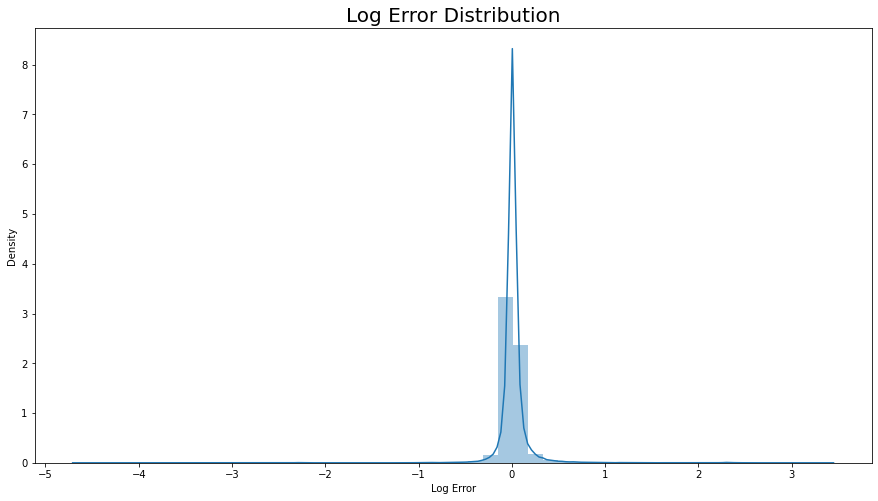

Takeawys: most of our log error are between -1 - 1. 
The min of logerror -4.65542037764
The max of logerror 3.39454406516
The mean of logerror 0.016667293763564062


In [6]:
#Plot again on the overall logerror distribution 
plt.figure(figsize=(15, 8)) #figure size
sns.distplot(df.logerror) #tell sns the feature that we would like to plot. 
plt.title('Log Error Distribution', fontsize=20)#set up the title 
plt.xlabel('Log Error')#set up the x label. 

plt.show()

print("Takeawys: most of our log error are between -1 - 1. ")
print(f'The min of logerror {df.logerror.min()}')
print(f'The max of logerror {df.logerror.max()}')
print(f'The mean of logerror {df.logerror.mean()}')

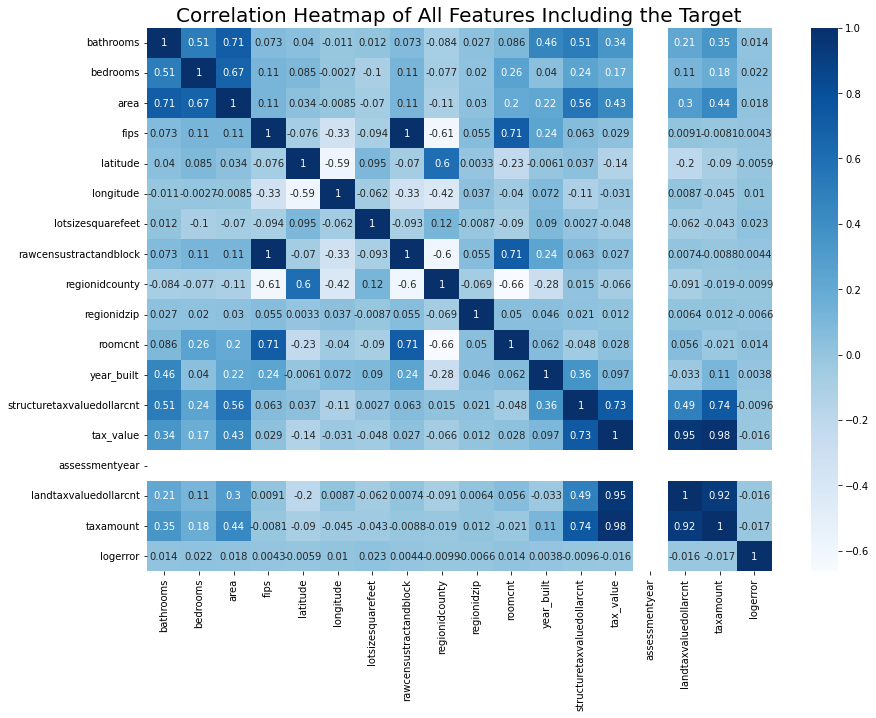

In [7]:
# Heatmap to display correlation of the features and logerror.
plt.figure(figsize=(14, 10))# set up the figure size. 
sns.heatmap(train.corr(), cmap='Blues', annot=True)# set up the heatmap, including color and annot. 
plt.title('Correlation Heatmap of All Features Including the Target', fontsize=20) # set upt the title and front size 
plt.show()

***Takeaways: The heatmap doesn't show any particulary high linear correlation but there could still be certain features that have more of an impact on the target variable.***

### What are the area that we are focusing on?

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#first import the library. 

In [9]:
# Extract the data we're interested in, reset the original longtitude and latitude by /100000
train.latitude = train.latitude/1000000
train.longtitude = train.longitude/1000000

Text(0.5, 1.0, "The Area We're Focusing On")

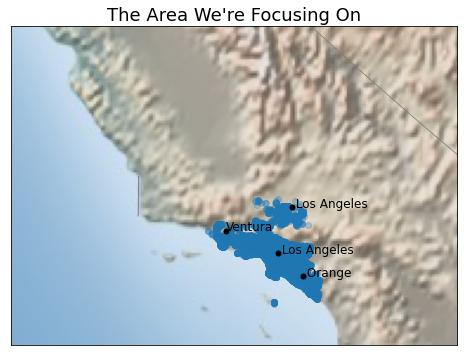

In [10]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8)) #set the gig size.
m = Basemap(projection='gnom', resolution='c', 
            lat_0=35, lon_0=-119,
            width=0.7E6, height=0.5E6) #set up the x, y and width and height. 
m.shadedrelief()
m.drawcoastlines(color='gray') 
m.drawcountries(color='gray')
m.drawstates(color='gray')#design this map. 
m.scatter(train.longtitude, train.latitude, latlon=True,
          cmap='Reds', alpha=0.3)
x, y = m(-118.2437, 34.0522) #google the LA location and mark it on the map. 
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, ' Los Angeles', fontsize=12);
x2, y2 = m(-117.8311, 33.7175)
plt.plot(x2, y2, 'ok', markersize=5)#google the orange county and mark it on the map. 
plt.text(x2, y2, ' Orange', fontsize=12);
x3, y3 = m(-119.1391, 34.3705)
plt.plot(x3, y3, 'ok', markersize=5)
plt.text(x3, y3, 'Ventura', fontsize=12);
x4, y4 = m(-118, 34.7)#goodle the ventura couty and mark it on the map. 
plt.plot(x4, y4, 'ok', markersize=5)
plt.text(x4, y4, ' Los Angeles', fontsize=12);#LA is big, including the north area, also mark it. 
plt.title("The Area We're Focusing On", fontsize=18)#Add title to this plot. 

***Takeaways: Ventura, Los Angeles and Orange are three couties we are focusing on.***

### Does the area of a home impact on logerror?

In [28]:
#H0:There is no relationship between logerror and area.
#H1: There is relationship between logerror and area. 

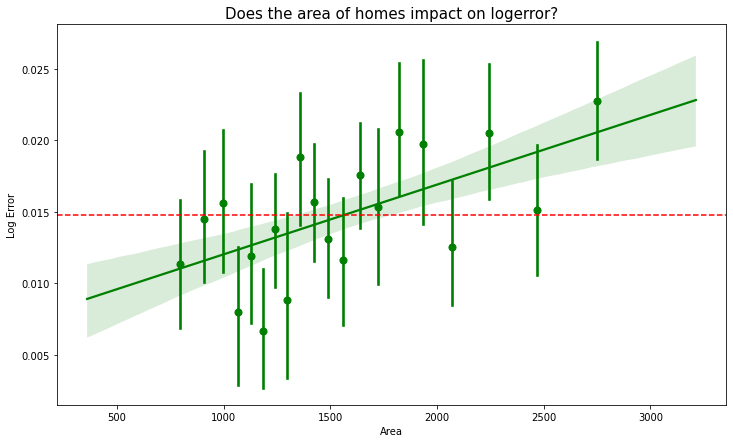

In [29]:

#Plot data and a linear regression model fit the area and logerror. 
plt.figure(figsize=(12,7))#set up the figure size.
sns.regplot(x=train.area, y=train.logerror, x_bins=20,ci=80, color = 'g')
# regplot can use on continuous feature by creating couple bins, 
#CI is  Size of the confidence interval for the regression estimate.I set to 80%, just to take a look the overall trend. 
plt.xlabel('Area')# set up the x axis. 
plt.ylabel('Log Error')# set up the y axis
plt.title('Does the area of homes impact on logerror?',fontsize=15) # set up the title and fontsize. 
mean1 = train.logerror.mean()# draw the mean of the logerror. 
plt.axhline(mean1, ls='--', color='red')#set the color to red, and line style. 
plt.show()

Looks like there is a linear relationship between area and logerror, let's run a test to further approve it.

In [26]:
alpha = 0.05
# Perform a corr test because both features are continuous features. 
corr, p = stats.pearsonr(train.logerror, train.area)
print(corr, p)
if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

0.018230903523404944 0.0004970886068872772
We reject the null hypothesis


***Takeaways: We have confidence to say there is a linear relationship between area and logerror.***

### Does bedroom counts impact log error?

In [30]:
# H0: Logerror for homes with 1,2,3 bedrooms == homes with 4,5,6 bedrooms. 
# H1:  Logerror for homes with 1,2,3 bedrooms != homes with 4,5,6 bedrooms. 

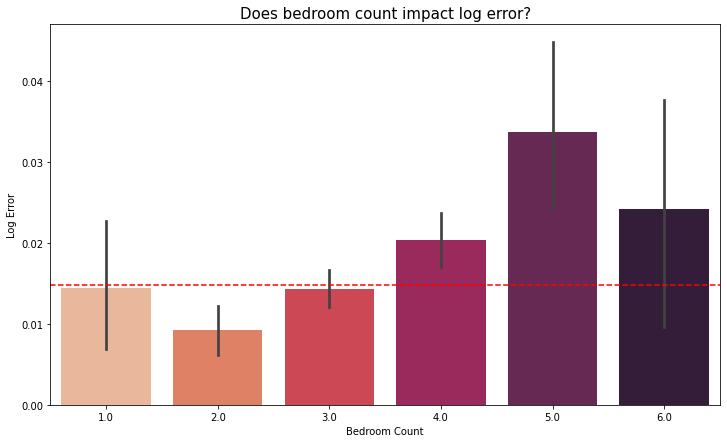

In [28]:
# let's plt it to check it out. 
plt.figure(figsize=(12,7))#set up the figure size
sns.set_palette(sns.color_palette("rocket_r")) #set the palette style. 
#with sns.color_palette("Blues"):
sns.barplot(x='bedrooms', y='logerror', data=train) #let's create a barplot!
plt.xlabel('Bedroom Count')# label the x axis.
plt.ylabel('Log Error')#label the y axis. 
plt.title('Does bedroom count impact log error?',fontsize=15)#set up the title.
mean1 = train.logerror.mean()#add mean of the logerror to this plt.
plt.axhline(mean1, ls='--', color='red')# set the mean line style. 

plt.show()

***Looks like homes with less bedrooms counts tend to produce smaller log error, bedrooms with 5 and 6 bedrooms counts have highestlogerror.let's run a t test to compare***

In [29]:
#create subsets to use t test. 
less_bedrooms = train[(train.bedrooms <=3)].logerror
more_bedrooms = train[(train.bedrooms > 3)].logerror 

# Perform a t test becuase we are comparsing two means,
# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(less_bedrooms,more_bedrooms, equal_var=False )
print(t, p)
if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

-5.103803881956084 3.37071365027959e-07
We reject the null hypothesis


***Takeaways: We have confidence to say that homes with less bedrooms counts tend to produce smaller log error.***

###  Do year_built related with logerror? 

In [ ]:
#H0:There is no relationship between logerror and year_built.
#H1: There is relationship between logerror and year_built. 

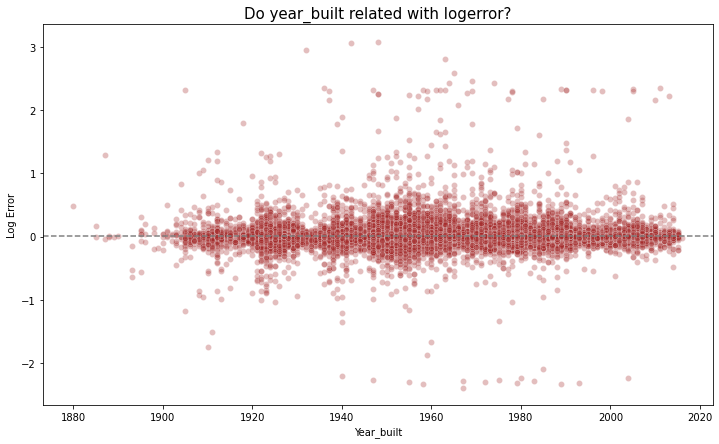

In [45]:
#first, we can create a scatterplot to see the distribution.  
plt.figure(figsize=(12,7)) # set up the figure size. 
sns.scatterplot(x='year_built', y='logerror', data=train,alpha=.3, color ='brown')# set up the x and y. 

mean1 = train.logerror.mean()# draw a logerror mean line 
plt.axhline(mean1, ls='--', color='grey')# set up the color and style

plt.xlabel('Year_built') # lable x 
plt.ylabel('Log Error')# lable y
plt.title('Do year_built related with logerror?',fontsize=15)# add title and set up fontsize. 
plt.show()

I'm unable to see the difference the relationship between year built and logerror, so I will run a test. 

In [74]:
# Perform a corr test because both features are continuous features. 
alpha = 0.05 # set up the alpha = 0.05 as normal. 
corr, p = stats.pearsonr(train.logerror, train.year_built)
print(corr, p)

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

0.005400631496055583 0.3023031599335249
We fail to reject the null hypothesis


***Takeaways: We can't say that we have confidence to say year_built are related with logerror.***

## Scale the Data

In [6]:
train.head()

,bathrooms,bedrooms,area,fips,lotsizesquarefeet,rawcensustractandblock,regionidcounty,roomcnt,year_built,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
24077,3.5,3.0,3011.0,6059.0,7313.0,6.059042e+07,1286.0,0.0,1986.0,264742.0,548381.0,2016.0,283639.0,6059.90,0.046818
5966,2.0,3.0,1304.0,6059.0,7800.0,6.059002e+07,1286.0,0.0,1963.0,83476.0,278141.0,2016.0,194665.0,3359.32,-0.017172
17777,2.5,4.0,2192.0,6059.0,25500.0,6.059022e+07,1286.0,8.0,1974.0,162562.0,485581.0,2016.0,323019.0,5290.26,-0.018572
35505,1.0,1.0,567.0,6037.0,189404.0,6.037407e+07,3101.0,0.0,1960.0,65991.0,152287.0,2016.0,86296.0,2021.01,0.366857
59009,1.5,3.0,1095.0,6059.0,7440.0,6.059100e+07,1286.0,6.0,1954.0,59690.0,472091.0,2016.0,412401.0,5668.88,0.021548


In [6]:
train=train.drop(columns=['latitude',
       'longitude',"regionidzip"])
validate = validate.drop(columns=['latitude',
       'longitude',"regionidzip"])
test =test.drop(columns=['latitude',
       'longitude',"regionidzip"])

In [7]:
## Scale our data. Columns that are suitble for scalling are, bedrooms, bathrooms, area, and home_age. 
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['bathrooms', 'bedrooms', 'area',  'lotsizesquarefeet', 'rawcensustractandblock',
        'roomcnt',
       'year_built', 'structuretaxvaluedollarcnt', 'tax_value',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount']
    #These columns are continuous features, suitble to scale. 
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()# create copy to avoid overwrite. 
    
    scaler = sklearn.preprocessing.MinMaxScaler() # import the min max scaler method. 
    scaler.fit(train[columns_to_scale]) # fit the data
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale]) #transform our data
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    #transform to scaled dataset. 
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [8]:
validate.shape

(15920, 15)

In [9]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)
#let's input our train validate and test data, and transform them all to scaled data.

In [10]:
#once we have scaled our data, then we will split out scaled data and ready for our model. 
X_train_scaled = train_scaled.drop(columns=['logerror'])
#Drop the tax_value because tax_value is our target variable. 
#Drop the county because I already hot encoded them. 
#Drop county_LA_county because, I encoded all county, even drop one columns make no difference. 
#Drop year_built because I created home age, and I can scale the home easier. 
X_validate_scaled = validate_scaled.drop(columns=['logerror'])
#duplicate the process on validate and test. 
X_test_scaled = test_scaled.drop(columns=['logerror'])

y_train = train[['logerror']]
#y_train only contains tax_value 
y_validate = validate[['logerror']]
#y_validate only contains tax_value 
y_test = test[['logerror']]
##y_test only contains tax_value 

In [11]:
round(X_train_scaled.mean()-X_validate_scaled.mean(),2)

bathrooms                     0.00
bedrooms                     -0.00
area                         -0.00
fips                          0.15
lotsizesquarefeet            -0.00
rawcensustractandblock        0.00
regionidcounty                1.68
roomcnt                       0.00
year_built                    0.00
structuretaxvaluedollarcnt   -0.00
tax_value                    -0.00
assessmentyear                0.00
landtaxvaluedollarcnt        -0.00
taxamount                    -0.00
dtype: float64

In [54]:
X_train_scaled.mean()

bathrooms                         0.372734
bedrooms                          0.381224
area                              0.421458
fips                           6049.064506
latitude                          0.453194
longitude                         0.662492
lotsizesquarefeet                 0.004036
rawcensustractandblock            0.165971
regionidcounty                 2511.898261
regionidzip                   96596.330982
roomcnt                           0.129866
year_built                        0.658086
structuretaxvaluedollarcnt        0.059018
tax_value                         0.079744
assessmentyear                    0.000000
landtaxvaluedollarcnt             0.051581
taxamount                         0.082405
dtype: float64

In [55]:
X_validate_scaled.mean()

bathrooms                     3.727282e-01
bedrooms                      3.825251e-01
area                          4.226855e-01
fips                          6.048912e+03
latitude                      2.311465e+07
longitude                     6.630542e-01
lotsizesquarefeet             4.041216e-03
rawcensustractandblock        1.639079e-01
regionidcounty                2.510220e+03
regionidzip                   9.661070e+04
roomcnt                       1.296744e-01
year_built                    6.578646e-01
structuretaxvaluedollarcnt    5.906166e-02
tax_value                     8.002420e-02
assessmentyear                0.000000e+00
landtaxvaluedollarcnt         5.184376e-02
taxamount                     8.257611e-02
dtype: float64

## First Cluster groups according to year built and area. 

In [16]:
cols = ['area','year_built']
X = X_train[cols]

NameError: name 'X_train' is not defined

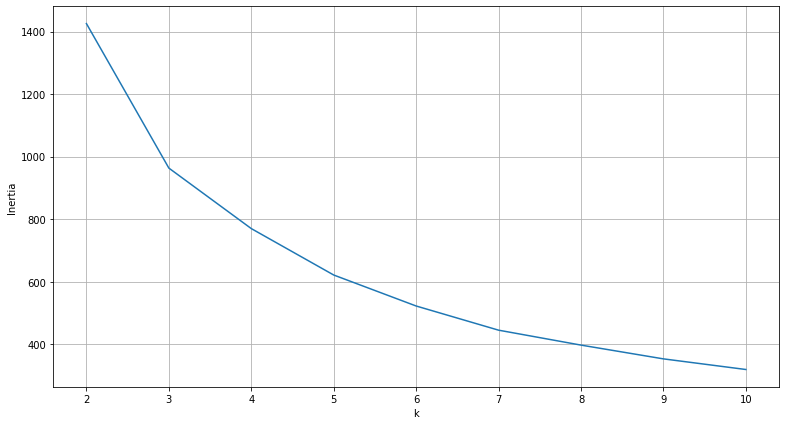

In [15]:
inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [16]:
kmeans = KMeans(n_clusters=4).fit(X)

In [17]:
X_train_scaled['year_area_cluster'] = kmeans.predict(X)
X_train_scaled.year_area_cluster = X_train_scaled.year_area_cluster.astype('category')
X_train_scaled.head()

,bathrooms,bedrooms,area,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,year_built,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,year_area_cluster
24077,0.833333,0.4,0.922087,6059.0,0.114587,0.906799,0.000987,0.296872,1286.0,96987.0,0.000000,0.788321,0.102418,0.108870,0.0,0.058283,0.100445,2
5966,0.333333,0.4,0.328348,6059.0,0.382910,0.822622,0.001057,0.296320,1286.0,97043.0,0.000000,0.620438,0.032024,0.054300,0.0,0.039923,0.055300,3
17777,0.500000,0.6,0.637217,6059.0,0.340338,0.872066,0.003596,0.296596,1286.0,97026.0,0.666667,0.700730,0.062736,0.096189,0.0,0.066410,0.087579,2
35505,0.000000,0.0,0.072000,6037.0,0.480231,0.783612,0.027110,0.004140,3101.0,96488.0,0.000000,0.598540,0.025233,0.028886,0.0,0.017561,0.032928,3
59009,0.166667,0.4,0.255652,6059.0,0.290061,0.768285,0.001005,0.297650,1286.0,96990.0,0.500000,0.554745,0.022786,0.093465,0.0,0.084854,0.093909,3


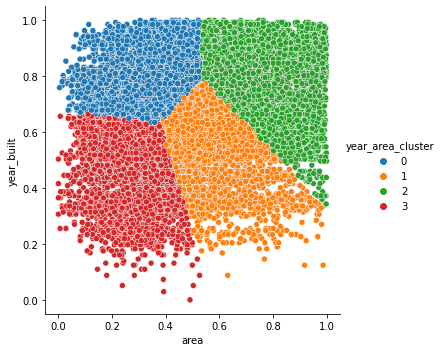

In [18]:
sns.relplot(data=X_train_scaled, y='year_built', x='area', hue='year_area_cluster')

(-1.0, 1.0)

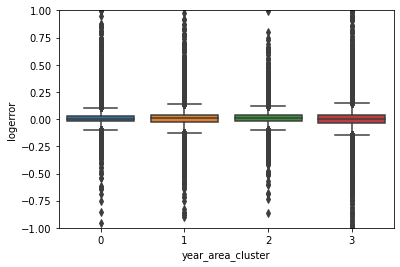

In [114]:
sns.boxplot(y=y_train.logerror, x=X_train_scaled.year_area_cluster)
plt.ylim(-1, 1)

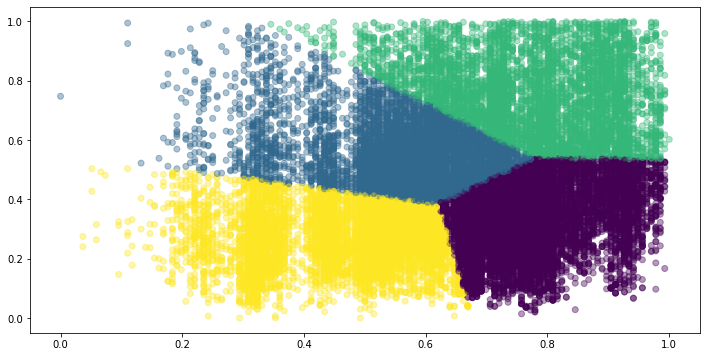

In [129]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X_train_scaled.area, x=X_train_scaled.year_built, c=X_train_scaled.year_area_cluster, alpha=.4)


In [ ]:
y_train = partitions[-3]

plt.scatter(y=y_train.logerror, x=X_train.age, c=X_train.area_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")


Not Useful

## Second Cluster groups according to lat and lon.

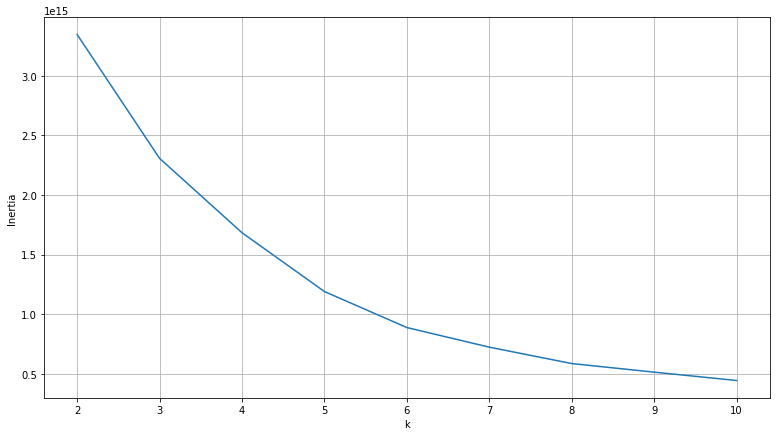

In [115]:
cols = ['latitude',
       'longitude']
X= X_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [116]:
kmeans = KMeans(n_clusters=5).fit(X)

In [108]:
X_train_scaled['lat_lon_cluster'] = kmeans.predict(X)
X_train_scaled.lat_lon_cluster = X_train_scaled.lat_lon_cluster.astype('category')
X_train_scaled.head()

,parcelid,bathrooms,bedrooms,area,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,transactiondate,county,bed_bath_cluster,bed_area_cluster,lat_lon_cluster,year_area_cluster
26056,14623197,0.166667,0.2,0.222222,6059.0,33610900.0,-117734000.0,7313.0,6.059063e+07,46098.0,...,0.036797,2016.0,93761.0,1917.34,2017-04-13,Orange,2,1,4,1
43394,14146568,0.666667,0.8,0.889940,6059.0,33905032.0,-117918724.0,12000.0,6.059002e+07,24812.0,...,0.103247,2016.0,266141.0,5819.14,2017-06-05,Orange,1,3,1,1
24259,14089120,0.500000,0.6,0.733964,6059.0,33745253.0,-118101934.0,5250.0,6.059100e+07,54352.0,...,0.120230,2016.0,273421.0,6925.66,2017-04-07,Orange,1,3,1,0
60093,10846719,0.333333,0.2,0.453558,6037.0,34171143.0,-118433278.0,8308.0,6.037129e+07,12447.0,...,0.142267,2016.0,437471.0,8567.59,2017-07-24,Los_Angeles,3,0,0,3
42860,12052468,0.333333,0.4,0.459516,6037.0,34175531.0,-118279416.0,9384.0,6.037301e+07,45457.0,...,0.017311,2016.0,42224.0,1099.36,2017-06-02,Los_Angeles,0,2,0,3


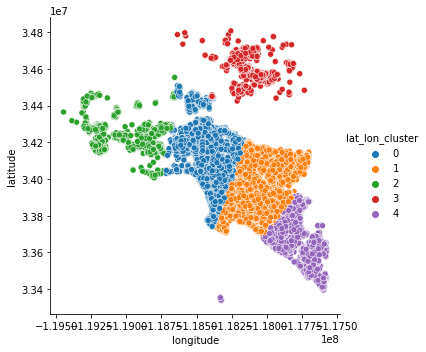

In [118]:
sns.relplot(data=X_train_scaled, y='latitude', x='longitude', hue='lat_lon_cluster')

(-1.0, 1.0)

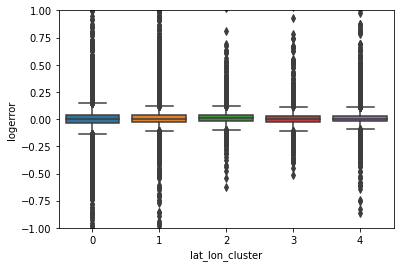

In [119]:
sns.boxplot(y=y_train.logerror, x=X_train_scaled.lat_lon_cluster)
plt.ylim(-1, 1)

In [ ]:
Not useful. 

## Third Cluster groups according to area and tax_value.

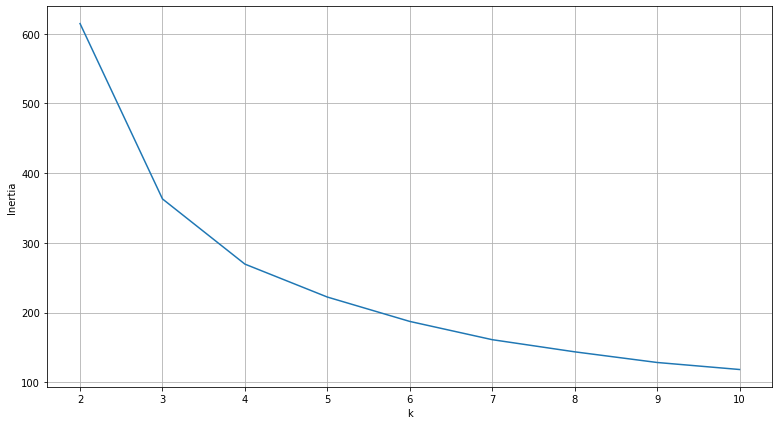

In [120]:
cols = ['area',
       'tax_value']
X= X_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [123]:
kmeans = KMeans(n_clusters=5).fit(X)

In [124]:
X_train_scaled['area_tax_cluster'] = kmeans.predict(X)
X_train_scaled.area_tax_cluster = X_train_scaled.area_tax_cluster.astype('category')
X_train_scaled.head()

,parcelid,bathrooms,bedrooms,area,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,assessmentyear,landtaxvaluedollarcnt,taxamount,transactiondate,county,bed_bath_cluster,bed_area_cluster,lat_lon_cluster,year_area_cluster,area_tax_cluster
26056,14623197,0.166667,0.2,0.222222,6059.0,33610900.0,-117734000.0,7313.0,6.059063e+07,46098.0,...,2016.0,93761.0,1917.34,2017-04-13,Orange,2,1,4,0,1
43394,14146568,0.666667,0.8,0.889940,6059.0,33905032.0,-117918724.0,12000.0,6.059002e+07,24812.0,...,2016.0,266141.0,5819.14,2017-06-05,Orange,1,3,1,2,2
24259,14089120,0.500000,0.6,0.733964,6059.0,33745253.0,-118101934.0,5250.0,6.059100e+07,54352.0,...,2016.0,273421.0,6925.66,2017-04-07,Orange,1,3,1,2,4
60093,10846719,0.333333,0.2,0.453558,6037.0,34171143.0,-118433278.0,8308.0,6.037129e+07,12447.0,...,2016.0,437471.0,8567.59,2017-07-24,Los_Angeles,3,0,0,1,0
42860,12052468,0.333333,0.4,0.459516,6037.0,34175531.0,-118279416.0,9384.0,6.037301e+07,45457.0,...,2016.0,42224.0,1099.36,2017-06-02,Los_Angeles,0,2,0,3,0


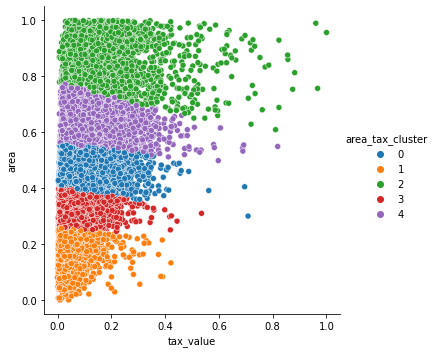

In [125]:
sns.relplot(data=X_train_scaled, y='area', x='tax_value', hue='area_tax_cluster')

(-1.0, 1.0)

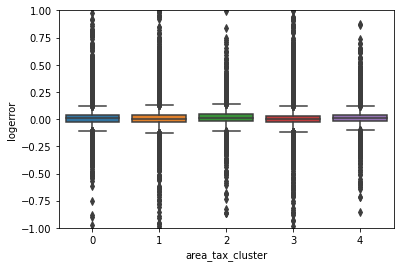

In [126]:
sns.boxplot(y=y_train.logerror, x=X_train_scaled.area_tax_cluster)
plt.ylim(-1, 1)

## Forth Cluster groups according to region and tax_value.

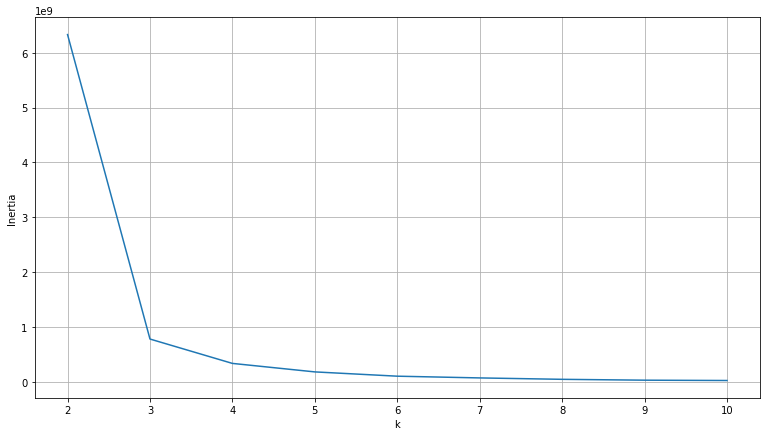

In [19]:
cols = ['regionidzip',
       'tax_value']
X= X_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [20]:
kmeans = KMeans(n_clusters=3).fit(X)

In [21]:
X_train_scaled['area_zip_cluster'] = kmeans.predict(X)
X_train_scaled.area_zip_cluster = X_train_scaled.area_zip_cluster.astype('category')
X_train_scaled.head()

,bathrooms,bedrooms,area,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,year_built,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,year_area_cluster,area_zip_cluster
24077,0.833333,0.4,0.922087,6059.0,0.114587,0.906799,0.000987,0.296872,1286.0,96987.0,0.000000,0.788321,0.102418,0.108870,0.0,0.058283,0.100445,2,0
5966,0.333333,0.4,0.328348,6059.0,0.382910,0.822622,0.001057,0.296320,1286.0,97043.0,0.000000,0.620438,0.032024,0.054300,0.0,0.039923,0.055300,3,0
17777,0.500000,0.6,0.637217,6059.0,0.340338,0.872066,0.003596,0.296596,1286.0,97026.0,0.666667,0.700730,0.062736,0.096189,0.0,0.066410,0.087579,2,0
35505,0.000000,0.0,0.072000,6037.0,0.480231,0.783612,0.027110,0.004140,3101.0,96488.0,0.000000,0.598540,0.025233,0.028886,0.0,0.017561,0.032928,3,2
59009,0.166667,0.4,0.255652,6059.0,0.290061,0.768285,0.001005,0.297650,1286.0,96990.0,0.500000,0.554745,0.022786,0.093465,0.0,0.084854,0.093909,3,0


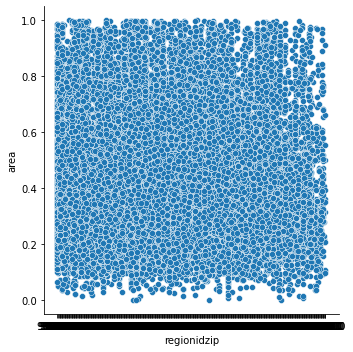

In [25]:
sns.relplot(data=X_train_scaled,y=X_train_scaled['area'], x=X_train_scaled['regionidzip'].astype(str)) #, hue='area_zip_cluster'

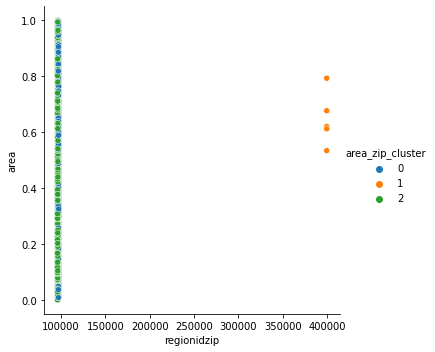

In [22]:
sns.relplot(data=X_train_scaled, y='area', x='regionidzip', hue='area_zip_cluster')

(-1.0, 1.0)

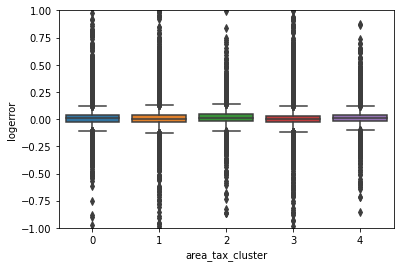

In [126]:
sns.boxplot(y=y_train.logerror, x=X_train_scaled.area_tax_cluster)
plt.ylim(-1, 1)

#Not Useful

## Modeling

## Baseline Model

In [12]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# The Project specs told us to use mean for our baseline
# 1. Predict tax_value_pred_mean
logerror_mean = y_train.logerror.mean()

y_train['logerror_mean'] = logerror_mean
y_validate['logerror_mean'] = logerror_mean

# 2. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_mean) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_mean) ** (0.5)

#create a dataframe, input the result. 
metric_df = pd.DataFrame(data=[
            {
                'model': 'Baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,0.161263,0.15789


### LinearRegression (OLS)

In [13]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37144 entries, 24077 to 63706
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathrooms                   37144 non-null  float64
 1   bedrooms                    37144 non-null  float64
 2   area                        37144 non-null  float64
 3   fips                        37144 non-null  float64
 4   lotsizesquarefeet           37144 non-null  float64
 5   rawcensustractandblock      37144 non-null  float64
 6   regionidcounty              37144 non-null  float64
 7   roomcnt                     37144 non-null  float64
 8   year_built                  37144 non-null  float64
 9   structuretaxvaluedollarcnt  37144 non-null  float64
 10  tax_value                   37144 non-null  float64
 11  assessmentyear              37144 non-null  float64
 12  landtaxvaluedollarcnt       37144 non-null  float64
 13  taxamount                  

In [14]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15920 entries, 74414 to 1936
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathrooms                   15920 non-null  float64
 1   bedrooms                    15920 non-null  float64
 2   area                        15920 non-null  float64
 3   fips                        15920 non-null  float64
 4   lotsizesquarefeet           15920 non-null  float64
 5   rawcensustractandblock      15920 non-null  float64
 6   regionidcounty              15920 non-null  float64
 7   roomcnt                     15920 non-null  float64
 8   year_built                  15920 non-null  float64
 9   structuretaxvaluedollarcnt  15920 non-null  float64
 10  tax_value                   15920 non-null  float64
 11  assessmentyear              15920 non-null  float64
 12  landtaxvaluedollarcnt       15920 non-null  float64
 13  taxamount                   

In [15]:
# I decided to use all features in x_train scaled to run model 2, 
# because all features are very important, and I want to see if this
# model can perfom better than RFE since there are more features. 
lm2 = LinearRegression()
lm2.fit(X_train_scaled, y_train.logerror)
# predict train
# 
# use the thing!
# 
y_train['OLS'] = lm2.predict(X_train_scaled)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.OLS) ** (1/2)

# predict validate
y_validate['OLS'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.OLS) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16110102219765712 
Validation/Out-of-Sample:  0.15775265516007914


In [16]:
#transform into dataframe. 
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,0.161263,0.157890
1,OLS Regressor,0.161101,0.157753


## Polynomial

In [17]:
# I decided to use polynomial for model 3. 
#Generate a new feature matrix consisting of all polynomial combinations 
#of the features with degree less than or equal to the specified degree.
# Polynomial provides the best approximation of the relationship between the dependent and independent variable. 
from sklearn.preprocessing import PolynomialFeatures

In [18]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree =2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)
# create the model object
lm2 = LinearRegression(normalie=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['polynomial'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.polynomial)**(1/2)

# predict validate
y_validate['polynomial'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.polynomial)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


TypeError: __init__() got an unexpected keyword argument 'normalie'

In [17]:
#transform result into dataframe. 
metric_df = metric_df.append({
    'model': 'polynomial', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,0.161263,0.157890
1,OLS Regressor,0.161090,0.157732
2,polynomial,0.161090,0.157732


## LassoLars Model

In [19]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, Ridge, Lasso


In [20]:
lars = LassoLars(alpha=0.01)
lars.fit(X_train_scaled, y_train.logerror)
y_train['Lassolars'] = lars.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.logerror, y_train.Lassolars) ** (1/2)
y_validate['Lassolars'] = lars.predict(X_validate_scaled)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.Lassolars) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1612634810675253 
Validation/Out-of-Sample:  0.15788992102796778


In [21]:
metric_df = metric_df.append({
    'model': 'LassoLars', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,0.161263,0.157890
1,OLS Regressor,0.161101,0.157753
2,LassoLars,0.161263,0.157890


In [22]:
ridge = LinearRegression()#Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train.logerror)
y_train['Ridge'] = ridge.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.logerror, y_train.Ridge) ** (1/2)
y_validate['Ridge'] = ridge.predict(X_validate_scaled)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate['Ridge']) ** (1/2)

print("RMSE for Kernel Regression Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Kernel Regression Model, degrees=2
Training/In-Sample:  0.16110102219765712 
Validation/Out-of-Sample:  0.15775265516007914


In [42]:
X_validate_scaled.mean()# - X_train_scaled.mean()

bathrooms                     3.727282e-01
bedrooms                      3.825251e-01
area                          4.226855e-01
fips                          6.048912e+03
latitude                      2.311465e+07
longitude                     6.630542e-01
lotsizesquarefeet             4.041216e-03
rawcensustractandblock        1.639079e-01
regionidcounty                2.510220e+03
regionidzip                   9.661070e+04
roomcnt                       1.296744e-01
year_built                    6.578646e-01
structuretaxvaluedollarcnt    5.906166e-02
tax_value                     8.002420e-02
assessmentyear                0.000000e+00
landtaxvaluedollarcnt         5.184376e-02
taxamount                     8.257611e-02
dtype: float64

In [38]:
X_train_scaled.mean()

bathrooms                         0.372734
bedrooms                          0.381224
area                              0.421458
fips                           6049.064506
latitude                          0.453194
longitude                         0.662492
lotsizesquarefeet                 0.004036
rawcensustractandblock            0.165971
regionidcounty                 2511.898261
regionidzip                   96596.330982
roomcnt                           0.129866
year_built                        0.658086
structuretaxvaluedollarcnt        0.059018
tax_value                         0.079744
assessmentyear                    0.000000
landtaxvaluedollarcnt             0.051581
taxamount                         0.082405
dtype: float64

In [33]:
y_validate

,logerror,logerror_mean,Lassolars,Ridge
74414,0.071250,0.014296,0.014296,-218368.397543
54599,-0.048308,0.014296,0.014296,-216361.288188
24265,0.009810,0.014296,0.014296,-216781.607894
33521,0.048124,0.014296,0.014296,-215471.142514
72914,-0.022723,0.014296,0.014296,-219809.246865
...,...,...,...,...
57030,-0.025609,0.014296,0.014296,-217964.063953
75581,0.131353,0.014296,0.014296,-216276.361239
71796,-0.002452,0.014296,0.014296,-215490.469542
75134,0.045015,0.014296,0.014296,-216559.920082


In [ ]:
X_train_scaled.shape